In [1]:
#reloads any packages before importing
%load_ext autoreload
%autoreload 2

# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

#import cv2

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

#Custom packages
import atp_cal

#RP plotting style
atp_cal.pboc_style_mpl()
# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'


## Data locations

In [2]:
#This should not change between experiments:
datapath = '../../data/atp_cal'

#This varies between experiments. 
#datafolder = '2023-12-16_A81D_Cal' #EDIT THIS EVERY TIME
datafolder = '2023-11-21_A81D_Cal' #EDIT THIS EVERY TIME

#IF YOU GLOB ALL FILES AND ARENT CONCERNED ABOUT A SPECIFIC TIMEPOINT
# # bound Images
# included_bound = '*uM*/*Pos*/*405*.tif' #EDIT THIS EVERY TIME
# bound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_bound))

# # unbound Images
# included_unbound = '*uM*/*Pos*/*480*.tif' #EDIT THIS EVERY TIME
# unbound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_unbound))

#IF YOU TOOK MULTIPLE TIME POINT, SPECIFY THE ONE YOU WANT AND MAKE THE LISTS BASED ON THIS:
included_time = '*uM*/*Pos*/*000000009*.tif'
files = glob.glob(datapath+'/'+datafolder+'/'+'*uM*/*Pos*/*000000009*.tif')
bound_files = [f for f in files if '405' in f]
unbound_files = [f for f in files if '480' in f]

#Find the ATP concentrations of each image
ATPconc_unsrt=[]
for i, file in enumerate(unbound_files):
    #conc = int(file.split('/')[5].split('_')[0].split('uM')[0]) #for 2023-12-16_A81D_Cal --> EDIT THIS EVERY TIME
    conc = int(file.split('uMATP')[0].split('_')[-1]) #for 2023-12-16_A81D_Cal --> EDIT THIS EVERY TIME
    ATPconc_unsrt.append(conc)
ATPconc_unsrt = np.array(ATPconc_unsrt)

#Find the indeces to sort the ATP concentrations and reorder
sorted_indices = np.argsort(ATPconc_unsrt)
ATPconc=ATPconc_unsrt[sorted_indices]

#Read in images and save as array:
bound_array_unsrt = atp_cal.file_to_image(bound_files)
unbound_array_unsrt = atp_cal.file_to_image(unbound_files)

#Sort the images
bound_array=bound_array_unsrt[sorted_indices]
unbound_array=unbound_array_unsrt[sorted_indices]

# Define the zero concentration image (DO EVERY TIME):
bound_zero = np.average(bound_array[np.where(ATPconc==0)], axis=0)
unbound_zero = np.average(unbound_array[np.where(ATPconc==0)], axis=0)

## Define background
Pick one of the following 3 methods

Method 1:
Uniformly subtract a single value

Method 2: Use a camera off image

In [3]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_files = np.sort(glob.glob(file_path_dark))
dark_ims = atp_cal.file_to_image(dark_files)
dark_avg = np.average(dark_ims, axis=0)

bound_bg = np.copy(dark_avg)
unbound_bg = np.copy(dark_avg)

Method 3: Use a no ATP and no ATeam image

## Subtract Background

In [4]:
bound_bs = bound_array - bound_bg
unbound_bs = unbound_array - unbound_bg

unbound_bs[unbound_bs<0] = 0
bound_bs[unbound_bs<0] = 0

bound_zero_bs = bound_zero - bound_bg
unbound_zero_bs = unbound_zero - unbound_bg

## Crop

In [5]:
#Creates crop window in pixels
win_size=400 # half length of the square crop sides
im_shape = bound_array[0].shape
centy, centx = im_shape[0]//2, im_shape[1]//2 #find center
ymin= centy - win_size
ymax= centy + win_size
xmin= centx - win_size
xmax= centx + win_size
crop_win=np.s_[ymin:ymax, xmin:xmax] #for single ims
crop_arrwin=np.s_[:,  ymin:ymax, xmin:xmax] #for arrays

## Correct for uneven illumination

In [6]:
def fit_bivariate_quadratic(image):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    image (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Get image dimensions
    M, N = image.shape

    # Create a meshgrid of coordinates
    i = np.arange(M)
    j = np.arange(N)
    I, J = np.meshgrid(i, j, indexing='ij')

    # Flatten the matrices for the least squares fitting
    I_flat = I.flatten()
    J_flat = J.flatten()
    Z_flat = image.flatten()

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly(image):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic(image);
    I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

def BivPolyNormMat(image):
    """Finds Normalization Matrix"""
    im_biv = evaluateBivPoly(image)
    alpha = np.nanmean(im_biv)/im_biv
    return alpha

Compute Normalization Matrices

In [7]:
norm_mat_bound = BivPolyNormMat(bound_zero_bs[crop_win])
norm_mat_unbound = BivPolyNormMat(unbound_zero_bs[crop_win])

just in case you want to show that the norm matrix for the averaged zeros is pretty much the same as the norm mat for the individual ims

In [8]:
testnorm = np.zeros((len(bound_bs[np.where(ATPconc==0)]), 2*win_size, 2*win_size))
for i, im in enumerate(bound_bs[np.where(ATPconc==0)]):
    testnorm[i]+=BivPolyNormMat(im[crop_win])
print(f'the bound norm matrix is the same within a range of {round(np.min(testnorm/norm_mat_bound)-1,4)} to {round(np.max(testnorm/norm_mat_bound)-1, 4)}')


the bound norm matrix is the same within a range of -0.0104 to 0.0118


Apply normalization Matrices

In [9]:
#Normalize all the calibration images by multiplying by the normalization matrix
bound_norm = bound_bs[crop_arrwin]*norm_mat_bound
unbound_norm = unbound_bs[crop_arrwin]*norm_mat_unbound

## Take the Ratio

In [10]:
ratio_im = bound_norm/unbound_norm
ratio_im[np.where(ratio_im==np.inf)] = np.nan
ratio_calavg = np.nanmean(ratio_im, axis=(1,2)) 

In [11]:
ratio_im.shape, ratio_calavg.shape

((60, 800, 800), (60,))

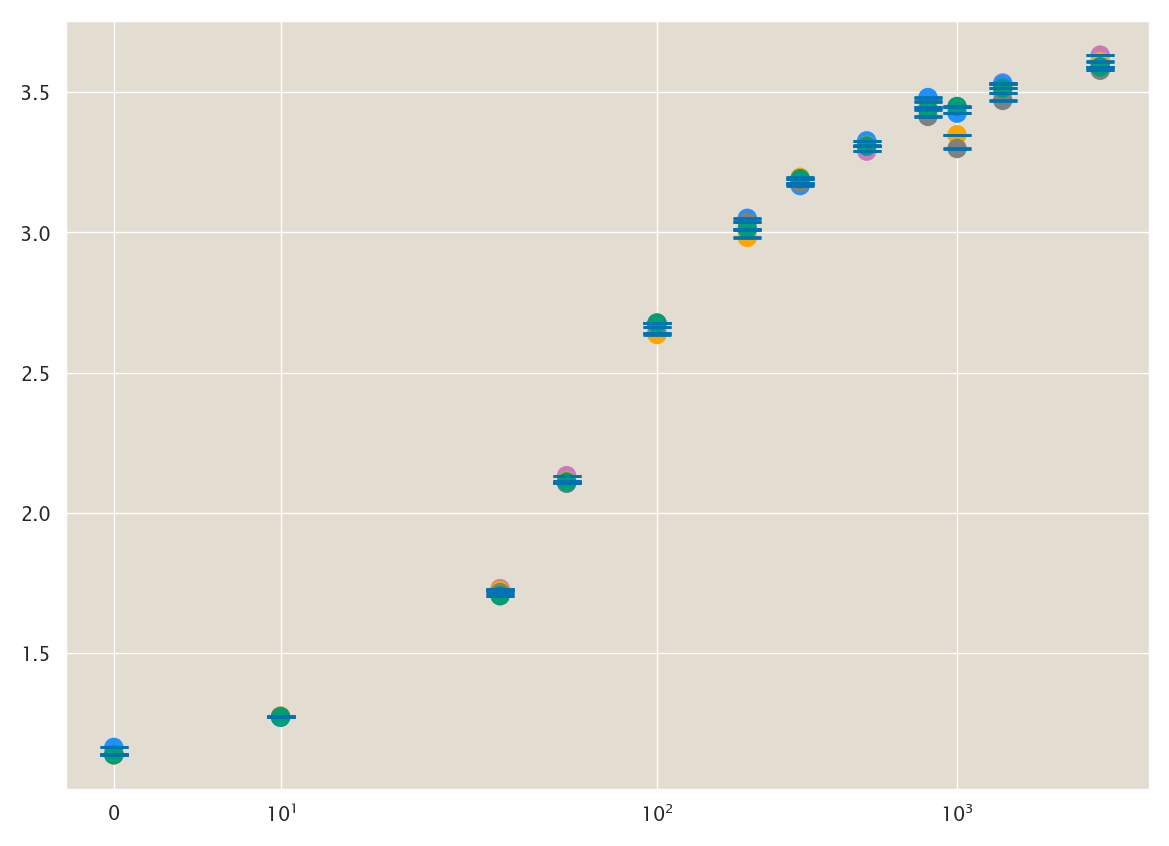

In [13]:
# # setup the normalization and the colormap
# normalize = mcolors.Normalize(vmin=testcolor.min(), vmax=0.6*testcolor.max())
# colormap = cm.viridis
# scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappable.set_array(plot_times)
#plotcolorindex = np.tile([1, 2, 3, 4], len(np.unique(ATPconc)))
plotcolor=np.tile(['m', 'dodgerblue', 'orange', 'gray', 'g'], len(np.unique(ATPconc)))
plt.scatter(ATPconc, ratio_calavg, color=plotcolor)
plt.errorbar(ATPconc, ratio_calavg, yerr = np.nanstd(ratio_im, axis=(1,2))/np.sqrt(win_size**2), fmt='None', capsize=5)
plt.xscale('symlog', linthresh=20)#, linscale=0.5)

In [14]:
ATPconc

array([   0,    0,    0,    0,    0,   10,   10,   10,   10,   10,   30,
         30,   30,   30,   30,   50,   50,   50,   50,   50,  100,  100,
        100,  100,  100,  200,  200,  200,  200,  200,  300,  300,  300,
        300,  300,  500,  500,  500,  500,  500,  800,  800,  800,  800,
        800, 1000, 1000, 1000, 1000, 1000, 1420, 1420, 1420, 1420, 1420,
       3000, 3000, 3000, 3000, 3000])

(array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

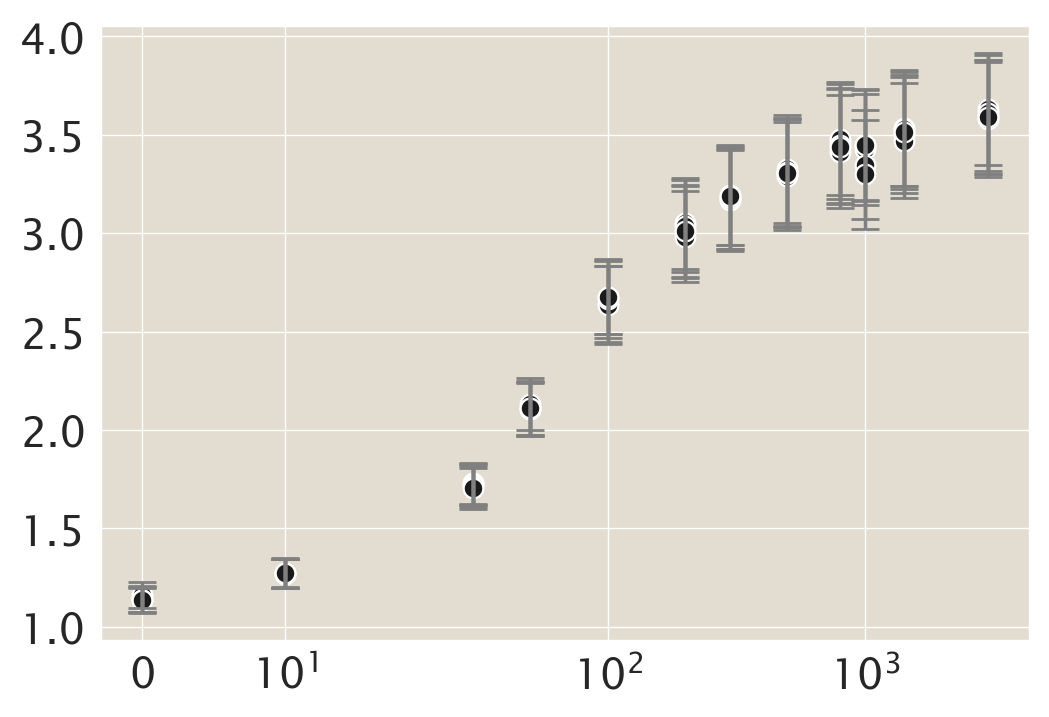

In [18]:
# FOR TIME BEING, for purposes of building up the capacity to fit with xerrors, 
# use these SYNTHETIC errors:
synthetic_conc_err = ATPconc*0.3

# Now plot
fig, ax = plt.subplots(figsize=(6,4))

plotcolor=np.tile(['m', 'dodgerblue', 'orange', 'gray'], len(np.unique(ATPconc)))
plt.scatter(ATPconc, ratio_calavg, color='k', marker='o', s=50, edgecolor='w', linewidth=0.8)#plotcolor)
plt.errorbar(ATPconc, ratio_calavg, yerr = np.nanstd(ratio_im, axis=(1,2)), 
             fmt='None', capsize=5, color='grey')
plt.xscale('symlog', linthresh=20)#, linscale=0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

<ErrorbarContainer object of 3 artists>

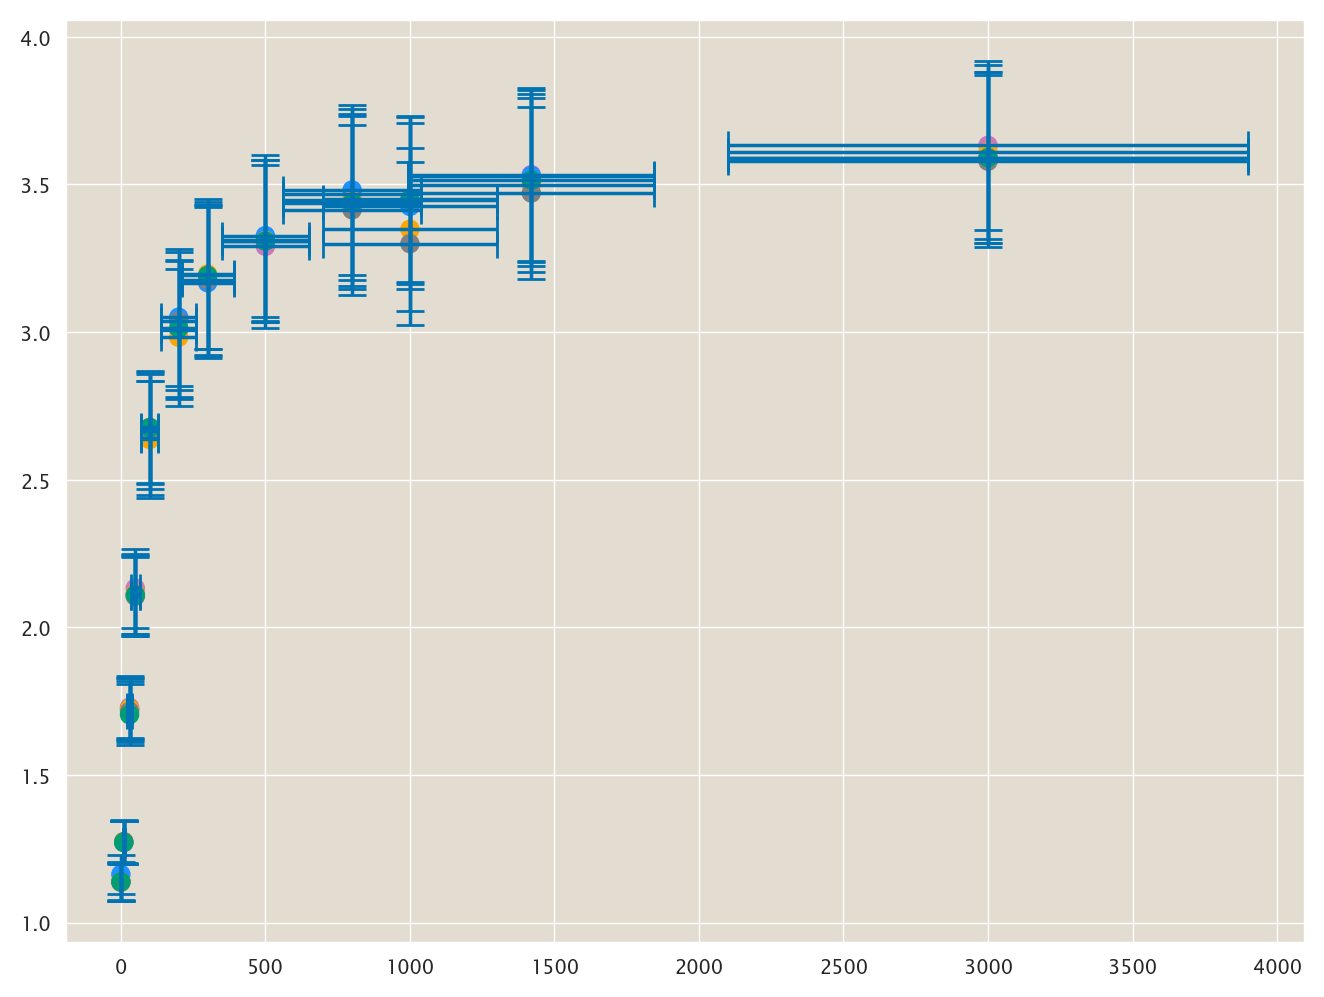

In [20]:
# FOR TIME BEING, for purposes of building up the capacity to fit with xerrors, 
# use these SYNTHETIC errors:
synthetic_conc_err = ATPconc*0.3

# Now plot
fig, ax = plt.subplots(figsize=(8,6))

plotcolor=np.tile(['m', 'dodgerblue', 'orange', 'gray', 'g'], len(np.unique(ATPconc)))
plt.scatter(ATPconc, ratio_calavg, color=plotcolor)
plt.errorbar(ATPconc, ratio_calavg, yerr = np.nanstd(ratio_im, axis=(1,2)), 
                                    xerr = synthetic_conc_err,
             fmt='None', capsize=5)
#plt.xscale('symlog', linthresh=20)#, linscale=0.5)

## Fit to a Michaelis_Menten Curve

In [21]:
#Langmuir equation
def Hill(conc, a, b, c):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """
    
    
    
    return (((b-c)*(conc/a)/(1+(conc/a)))+c)



#Curve-fit to the Langmuir curve
def Hill_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 3 entries of parameter guesses for a, b, and c in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(3), np.ones([3])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = Hill(xvals, param[0], param[1], param[2])
    
    return param, curve, xvals

#Curve-fit to the Langmuir curve
def curve_fit_with_yerr(conc, calavg, maxconc, p0, yerr):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 3 entries of parameter guesses for a, b, and c in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(Hill, 
                                 conc, 
                                 calavg, 
                                 p0,
                                 sigma=yerr,
                                 absolute_sigma=True,
                                 bounds = (np.zeros(3), np.ones([3])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = Hill(xvals, param[0], param[1], param[2])
    
    return param, curve, xvals, param_cov

def weighted_res(hill_params, xvals, yvals, xerr, yerr):
    """
    xvals = average of x valuse
    yvals = average of y values
    xerr = standard deviation of x values
    yerr = standard deviation of y values
    """
    
    #the parameters minimize will fit
    a, b, c = hill_params
   
    #the error in yvalues due to error in the xvalues df/dx at a value x* with parameters a, b, c, where f is the hill function input
    yerr_from_xerr = (a*(b-c)/(a+xvals)**2)*xerr
    
    
    #define the combined error in y from the variation of y values AND the error in x values squared(in quadrature)
    yerr_tilde_sq = yerr**2 + yerr_from_xerr**2
    
    return np.sum((Hill(xvals, a, b, c)-yvals)**2/yerr_tilde_sq)


def min_weight_fit(xvals, yvals, xerr, yerr, p0, method='BFGS'):
    """
    Performs a curve fitting using scipy.optimize.minimize to fit data to a Langmuir curve
    
    Parameters
    
    p0 = 1D list with 3 entries of parameter guesses for a, b, and c in the Hill function
    
    Returns

    """
    
    #(use method BFGS for best friend Gabe Salmon!!!)
    result = optimize.minimize(weighted_res, p0, args=(xvals, yvals, xerr, yerr), method=method, bounds = np.array([np.zeros(3), np.ones([3])*np.inf]).T)
    
    return result

In [22]:
min_bfgs = min_weight_fit(ATPconc, ratio_calavg, xerr = np.zeros_like(synthetic_conc_err), yerr = np.nanstd(ratio_im, axis=(1,2)), p0=[100, 1, 0.5], method='BFGS')
min_constr = min_weight_fit(ATPconc, ratio_calavg, xerr = np.zeros_like(synthetic_conc_err), yerr = np.nanstd(ratio_im, axis=(1,2)), p0=[100, 1, 0.5], method='trust-constr')

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:538: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [23]:
min_bfgs

      fun: 19.304919165679276
 hess_inv: array([[ 8.06418613e-05, -1.29882824e-04,  4.72919256e-05],
       [-1.29882824e-04,  2.75882701e-04, -1.65613458e-04],
       [ 4.72919256e-05, -1.65613458e-04,  1.88986037e-04]])
      jac: array([5.24520874e-06, 5.24520874e-06, 1.81198120e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 364
      nit: 23
     njev: 87
   status: 2
  success: False
        x: array([87.32866705,  3.72070523,  1.08947212])

In [60]:
min_constr

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 141
      cg_stop_cond: 4
            constr: [array([79.93011357,  3.75931171,  1.07904063])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.1207280158996582
               fun: 1.783159108647992
              grad: array([1.86427374e-09, 6.65918465e-07, 9.39055427e-07])
               jac: [<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([1.83836361e-09, 6.21403620e-07, 5.04156001e-07])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 280
              nhev: 0
               nit: 89
             niter: 89
              njev: 70
        optimality: 6.214036198600886e-07
            status: 2
           success: True
         tr

In [61]:
np.einsum('i,j->ij', np.array(min_constr.jac).T, np.array(min_constr.jac))

TypeError: invalid data type for einsum

In [134]:
np.linalg.inv(np.outer(min_bfgs.jac, min_bfgs.jac))

LinAlgError: Singular matrix

In [119]:
np.linalg.inv((min_bfgs.jac@min_bfgs.jac.T))

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [111]:
min_constr

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 141
      cg_stop_cond: 4
            constr: [array([79.93011357,  3.75931171,  1.07904063])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.10989499092102051
               fun: 1.783159108647992
              grad: array([1.86427374e-09, 6.65918465e-07, 9.39055427e-07])
               jac: [<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([1.83836361e-09, 6.21403620e-07, 5.04156001e-07])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 280
              nhev: 0
               nit: 89
             niter: 89
              njev: 70
        optimality: 6.214036198600886e-07
            status: 2
           success: True
         t

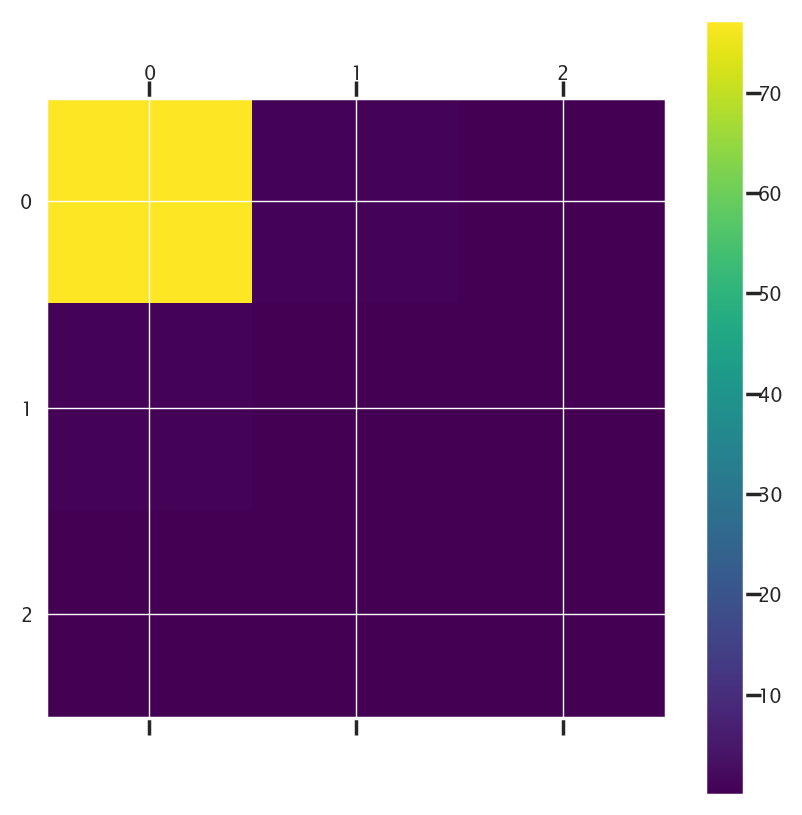

In [105]:
plt.matshow(min_bfgs.hess_inv)
plt.colorbar()

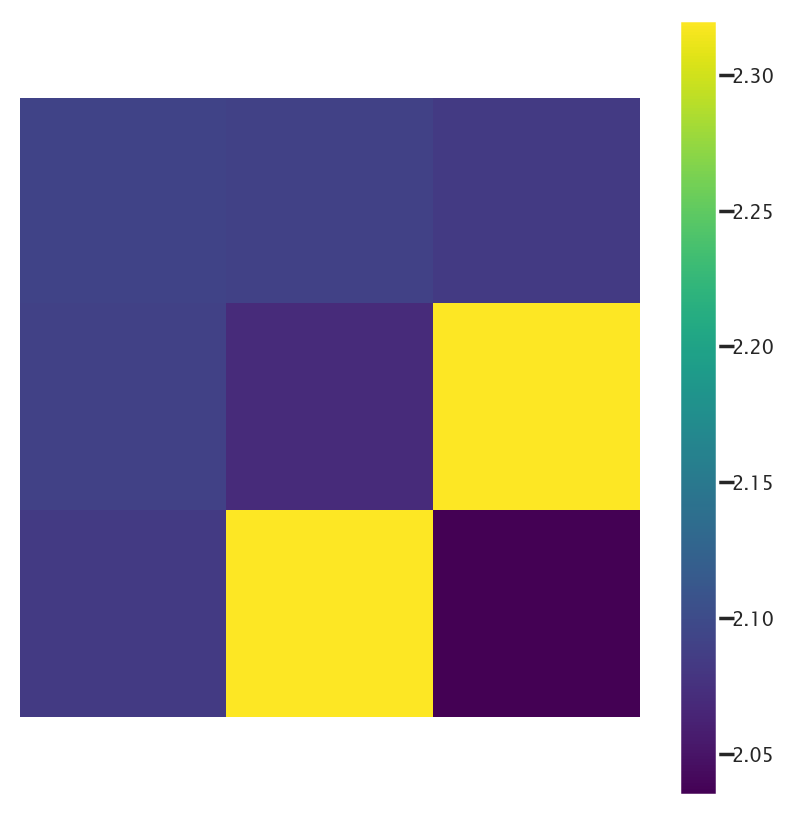

In [73]:
plt.matshow(pcov/i_think_this_works_noxerr.hess_inv)
plt.axis('off')
plt.colorbar()

In [66]:
params, curve, xvals, pcov = curve_fit_with_yerr(ATPconc[:], ratio_calavg[:], np.max(ATPconc), [300, 1, 0.5], np.nanstd(ratio_im, axis=(1,2)))
print(params)
print(pcov)
 
# plt.scatter(ATPconc[:], ratio_calavg[:], label = 'Data')
# plt.xscale('symlog')
# plt.plot(xvals, curve, label=f'$K_M$={round(params[0])}, $R_\infty$={round(params[1],2)}, $R_0$={round(params[2],2)}')
# plt.legend(loc = 'lower right')
# plt.xlabel('ATP Concentration (µM)')
# plt.ylabel('Intensity (A.U.)')
# plt.title('ATP Calibration Curve')

[79.93010727  3.75931169  1.07904062]
[[1.61595136e+02 1.26674269e+00 2.60302939e-01]
 [1.26674269e+00 1.96958007e-02 5.96837433e-04]
 [2.60302939e-01 5.96837433e-04 2.84776907e-03]]


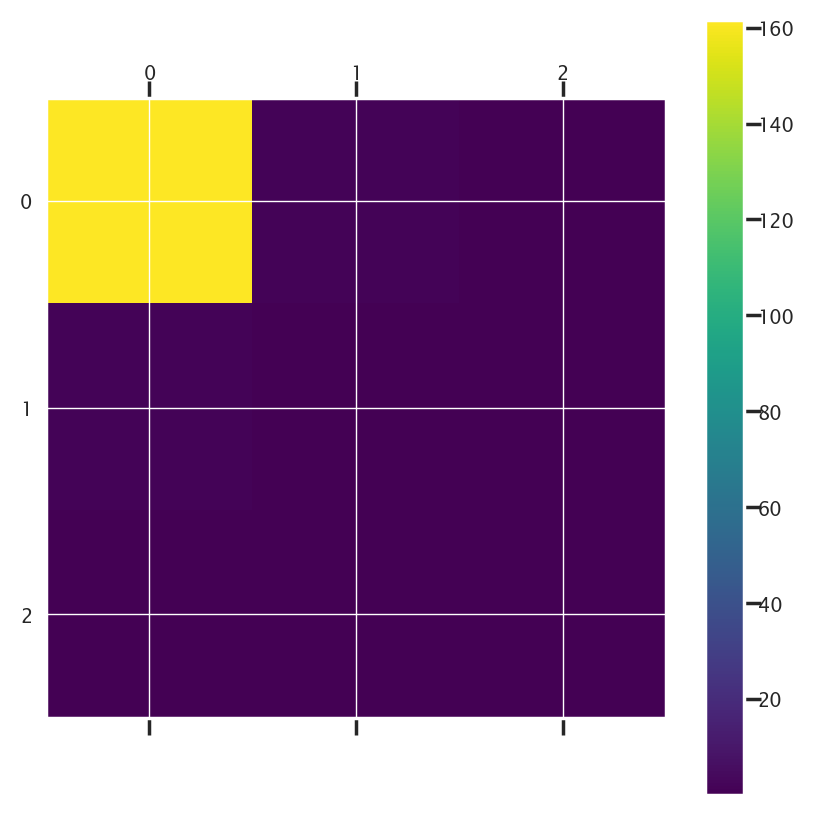

In [70]:
plt.matshow(pcov)
plt.colorbar()

[70.9562658   3.6476895   1.04248721]


Text(0.5, 1.0, 'ATP Calibration Curve')

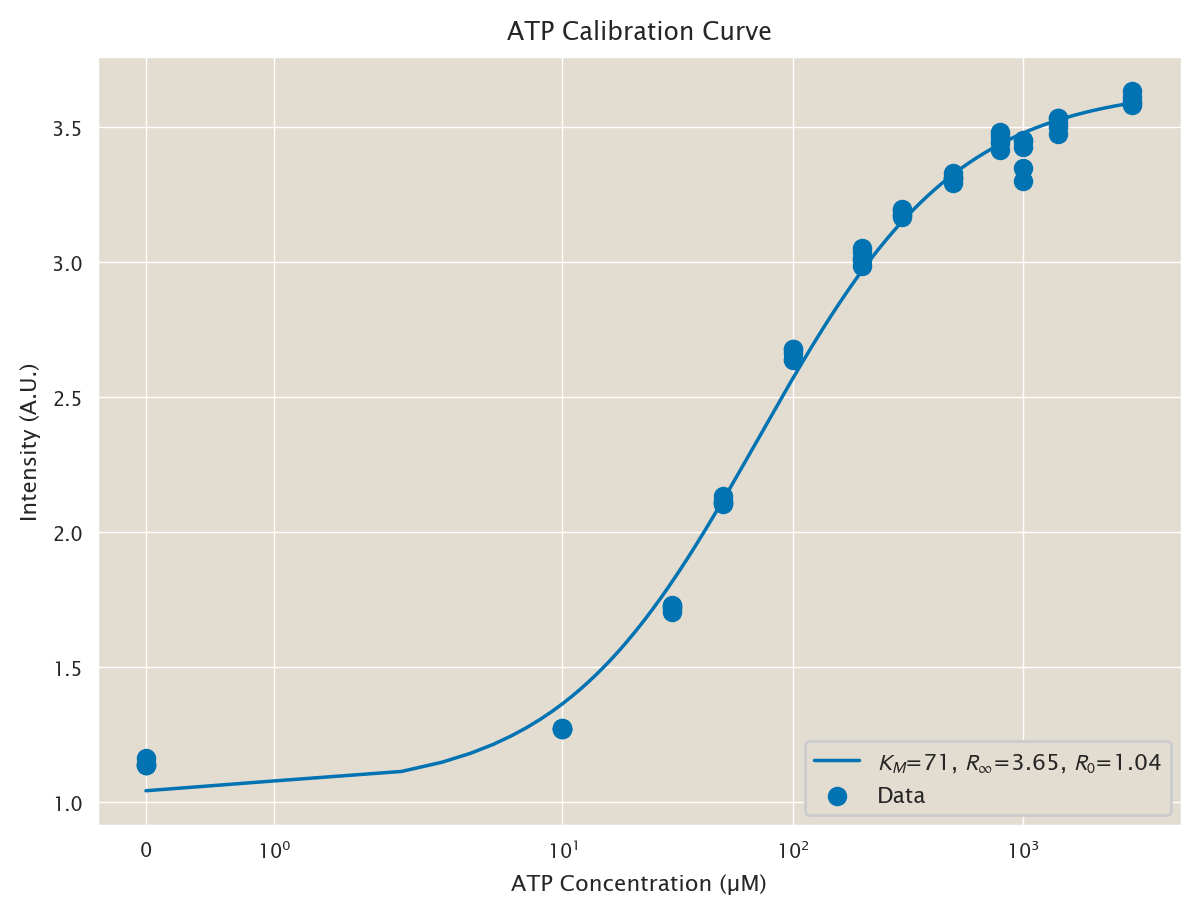

In [24]:
params, curve, xvals = Hill_curve_fit(ATPconc[:], ratio_calavg[:], np.max(ATPconc), [300, 1, 0.5])
print(params)

plt.scatter(ATPconc[:], ratio_calavg[:], label = 'Data')
plt.xscale('symlog')
plt.plot(xvals, curve, label=f'$K_M$={round(params[0])}, $R_\infty$={round(params[1],2)}, $R_0$={round(params[2],2)}')
plt.legend(loc = 'lower right')
plt.xlabel('ATP Concentration (µM)')
plt.ylabel('Intensity (A.U.)')
plt.title('ATP Calibration Curve')

[70.9562658   3.6476895   1.04248721]


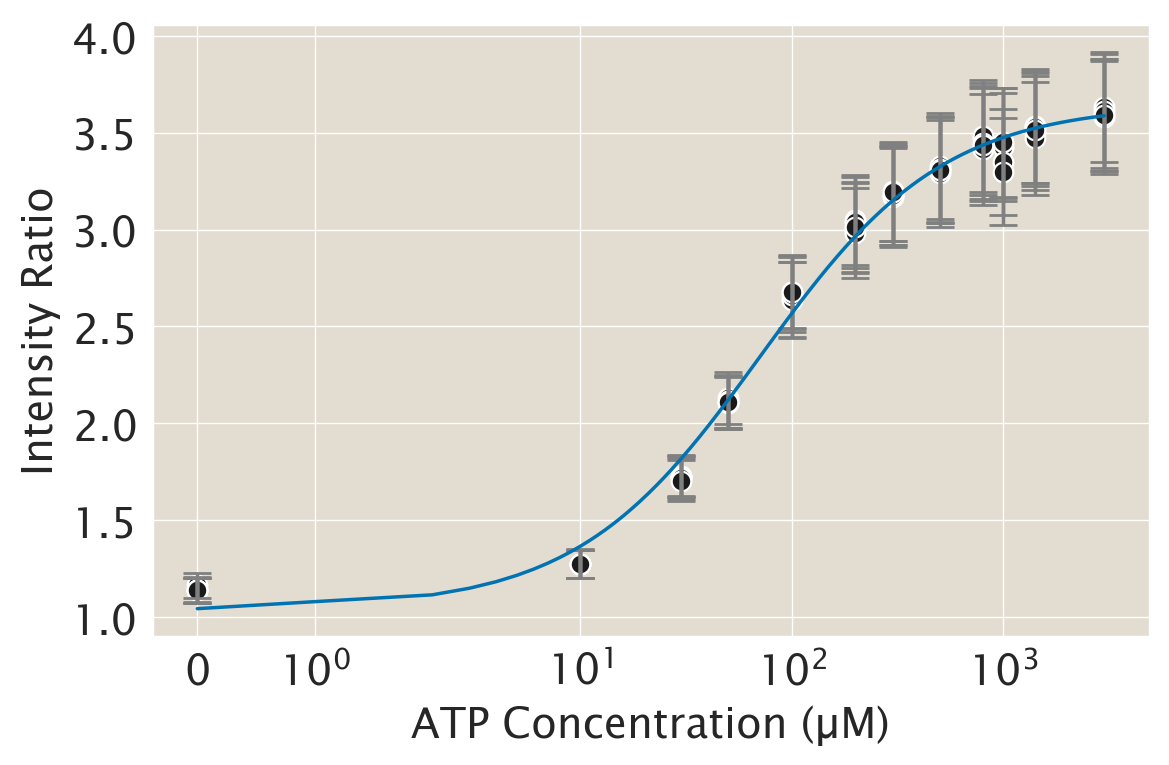

In [25]:
params, curve, xvals = Hill_curve_fit(ATPconc[:], ratio_calavg[:], np.max(ATPconc), [300, 1, 0.5])
print(params)

# Now plot
fig, ax = plt.subplots(figsize=(6,4))

plotcolor=np.tile(['m', 'dodgerblue', 'orange', 'gray'], len(np.unique(ATPconc)))
plt.scatter(ATPconc, ratio_calavg, color='k', marker='o', s=50, edgecolor='w', linewidth=0.8)#plotcolor)
plt.errorbar(ATPconc, ratio_calavg, yerr = np.nanstd(ratio_im, axis=(1,2)), 
             fmt='None', capsize=5, color='grey')
plt.plot(xvals, curve, label=f'$K_M$={round(params[0])}, $R_\infty$={round(params[1],2)}, $R_0$={round(params[2],2)}')
plt.xscale('symlog')#, linthresh=20)#, linscale=0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('ATP Concentration (µM)', fontsize=15)
plt.ylabel('Intensity Ratio', fontsize=15)
plt.tight_layout()
plt.savefig('../../analyzed_data/atp_cal/'+datafolder+'/atp_cal.pdf')

## Save

In [32]:
import time
time.time()
savename = '__2024-07-23_ATPCal_Pipeline__analyzedOn'+now.strftime("%Y%m%d_%H%M%S")

df_fit = pd.DataFrame({'Param' : ['Km', 'Rmax', 'Rmin'], 'Value' : params})
df_fit.to_csv('../../analyzed_data/atp_cal/' + datafolder + '/df_fit_bivnorm'+savename)

df_data = pd.DataFrame({'ATP uM' : ATPconc, 'Ratio' : ratio_calavg})
df_data.to_csv('../../analyzed_data/atp_cal/' + datafolder + '/df_data_bivnorm'+savename)

In [31]:
from datetime import datetime
now = datetime.now()
now.strftime("%Y%m%d_%H%M%S")#'20241113' #'../../analyzed_data/aster/2023-12-12_NCD_Aster/SAVE1OMG.h5'

'20241219_121831'